# Introduction to Neural Language Models using PyTorch
We want to predict

$$\hat{P}(w_i \mid w_1, \dots, w_{i-1})$$

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

In [2]:
import string
import nltk
import matplotlib.pyplot as plt

## Case study
We aim at training a network for a Movie in the Movie-Dialog dataset. Instead of using simple tokens, we create artificial tokens by combining a token with its part-of-speech.

**Example**

In [3]:
from langmodels.corpora.moviedialog import MovieDialogCollection

In [4]:
db_name = 'movie-dialogs'
collection = 'lines'
m = {'$match': {'character.movie.id': 'm42'}}
p = {'$project': {'_id': 0, 'id': 1, 'text': 1}}
pipeline = [m, p]

In [5]:
m42 = MovieDialogCollection(db_name, collection, 
                            use_pos=False, mix_pos=True, pipeline=pipeline)

In [6]:
tokens = m42.get_tokens()

In [7]:
print(tokens[0])

('L119167', ['--_PUNCT', 'he_PRON', "'s_VERB", 'just_ADV', 'a_DET', 'lucky_ADJ', 'guy_NOUN', '._PUNCT'])


## Word embeddings
Since we do not have single words, but words plus POS, we cannot use a pre-trained word embedding model. Thus, we create one custom model, using a larger corpus (see the [example](https://github.com/afflint/inforet/blob/master/thematic-studies/language-models/L04-wordembeddings.ipynb))

In [8]:
ug = {'$unwind': '$character.movie.genres'}
mg = {'$match': {'character.movie.genres': {'$in': ['drama']}}}
pg = {'$project': {'_id': 0, 'id': 1, 'text': 1}}
pipeline = [ug, mg, pg]

In [9]:
general = MovieDialogCollection(db_name, collection, 
                                use_pos=False, 
                                mix_pos=True, pipeline=pipeline)

sequences = []
for doc, tokens in general.get_skip_tokens(n=3, s=2):
    for a, b, c in tokens:
        sequences.append([a, b, c])

print(len(sequences), sequences[0])

In [10]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

embedding_model = Word2Vec(sequences, min_count=30)

embedding_model.wv.most_similar(positive='can_VERB')[:5]

embedding_model.save('langmodels/corpora/token_pos.word2vec')

### Load model

In [11]:
embedding_model = Word2Vec.load('../../data/token_pos.word2vec')

### Create an embedding matrix for feeding the network
For each word in dataset’s vocabulary, we check if it is on Word2Vec vocabulary. If it do it, we load its pre-trained word vector. Otherwise, we initialize a random vector. Moreover, we add two special random vectors for the start sentence token `#S` and the end token `#E`.

In [12]:
V = m42.vocabulary + ['#S', '#E']

In [13]:
word2idx = dict([(w, i) for i, w in enumerate(V)])

In [14]:
embedding_matrix = np.zeros((len(V), embedding_model.vector_size))
for word, i in word2idx.items():
    try: 
        embedding_matrix[i] = embedding_model.wv[word]
    except KeyError:
        embedding_matrix[i] = np.random.normal(size=(embedding_model.vector_size, ))

**Check**

In [15]:
embedding_model.wv['he_PRON'] - embedding_matrix[word2idx['he_PRON']]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Create a model embedding layer
We now create an embedding layer to be used as input for the network. This is non trainable, because we already have fitted it with the pre-trained word embedding model.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [17]:
def create_emb_layer(embedding_matrix, non_trainable=True):
    num_embeddings, embedding_dim = embedding_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.tensor(embedding_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

In [18]:
E = create_emb_layer(embedding_matrix, non_trainable=True)

## Create a simple NGram language model
Simple example taken from [pytorch tutorials](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)

In [19]:
import nltk

In [20]:
class NGLM(nn.Module):

    def __init__(self, vocab_size, embedding_matrix, context_size):
        super(NGLM, self).__init__()
        e, ne, embedding_dim = create_emb_layer(embedding_matrix, non_trainable=True)
        self.embeddings = e
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [21]:
losses = []
loss_function = nn.NLLLoss()
model = NGLM(len(V), embedding_matrix, 2)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [22]:
trigrams = []
for doc, tokens in m42.get_tokens():
    trigrams += [([a, b], c) for a, b, c in nltk.ngrams(['#S'] + tokens + ['#E'], 3)]

### Understand the input

In [23]:
print(trigrams[0])

(['#S', '--_PUNCT'], 'he_PRON')


In [24]:
epochs = tqdm_notebook(list(range(10)))
for epoch in epochs:
    total_loss = 0
    for context, target in trigrams:
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word2idx[w] for w in context], dtype=torch.long)
        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()
        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word2idx[target]], dtype=torch.long))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)

In [25]:
import matplotlib.pyplot as plt

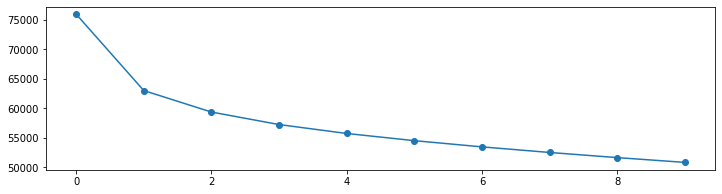

In [26]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(losses, marker='o')
plt.show()

In [27]:
prediction = model(torch.tensor([word2idx['he_PRON'], word2idx['is_VERB']]))

In [28]:
V[prediction.argmax().item()]

"n't_ADV"

In [68]:
for context, c in trigrams[:10]:
    p = model(torch.tensor([word2idx[context[0]], word2idx[context[1]]]))
    print([context[0].split('_')[0], context[1].split('_')[0]], V[p.argmax().item()])

['#S', '--'] i_PRON
['--', 'he'] 's_VERB
['he', "'s"] a_DET
["'s", 'just'] a_DET
['just', 'a'] little_ADJ
['a', 'lucky'] ._PUNCT
['lucky', 'guy'] ._PUNCT
['guy', '.'] #E
['#S', 'monsieur'] ,_PUNCT
['monsieur', 'rick'] ._PUNCT


## Evaluate

In [29]:
def predict(a, b):
    try:
        p = model(torch.tensor([word2idx[a], word2idx[b]]))
        out = V[p.argmax().item()]
    except KeyError:
        p = None
        out = None
    return out, p

In [38]:
tp, fp, fn = 0, 0, len(trigrams[:100])
for context, c in trigrams[:100]:
    w, p = predict(context[0], context[1])
    predicted_words = [V[i] for i, e in sorted(enumerate(p[0]), key=lambda x: -x[1])[:5]]
    if c in predicted_words:
        tp += 1
        fn -= 1
    else:
        fp += 1

In [39]:
print(tp / (tp + fp), tp / (tp + fn))

0.43 0.43


In [40]:
_, l = predict('#S', 'he_PRON')

In [41]:
e = np.exp(l[0].detach().numpy())
for i, e in sorted(enumerate(e), key=lambda x: -x[1])[:10]:
    print(V[i], e)

's_VERB 0.3482869
is_VERB 0.0929797
'll_AUX 0.068929285
was_VERB 0.060862683
will_VERB 0.024446791
did_VERB 0.016158903
are_VERB 0.015797095
._PUNCT 0.014419636
,_PUNCT 0.014077187
!_PUNCT 0.011798351


In [44]:
def generate(start='#S', max_len=10):
    text = [start, start]
    for w in range(max_len):
        w, prediction = predict(text[-2], text[-1])
        next_word = np.random.choice(V, p=np.exp(prediction.detach().numpy()[0]))
        text.append(next_word)
        if next_word == '#E':
            break
    return text

In [46]:
generate()

['#S',
 '#S',
 'your_DET',
 'compliment_NOUN',
 'want_VERB',
 'you_PRON',
 'come_VERB',
 'romantic_ADJ',
 'people_NOUN',
 'are_VERB',
 'very_ADV',
 '._PUNCT']